In [32]:
import re
import ast
import pickle
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functional import seq
from loguru import logger
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)

import sys
sys.path.append(".")
sys.path.append("D:\Code\Mine\occupational_health_system_v2")
from comparasion_between_AC import get_importance_from_regressor, catboost_regressor_params


In [2]:
df = pd.read_csv("./results/extract_df.csv", header=0, index_col="staff_id")
df.head(1)

,NIPTS,NIPTS_1000,NIPTS_2000,NIPTS_3000,NIPTS_4000,NIPTS_6000,Leq,LAeq,LCeq,Ieq,...,SPL_16000_geomean,Leq_63,Leq_125,Leq_250,Leq_500,Leq_1000,Leq_2000,Leq_4000,Leq_8000,Leq_16000
staff_id,,,,,,,,,,,,,,,,,,,,,
Gengde electronic equipment factory-0,9.0,19.0,16.0,10.0,9.0,8.0,99.808967,97.332718,96.446445,9.569664e+09,...,78.208997,78.537962,82.108443,83.231912,85.032543,86.502641,87.927498,91.410782,94.654844,94.562525


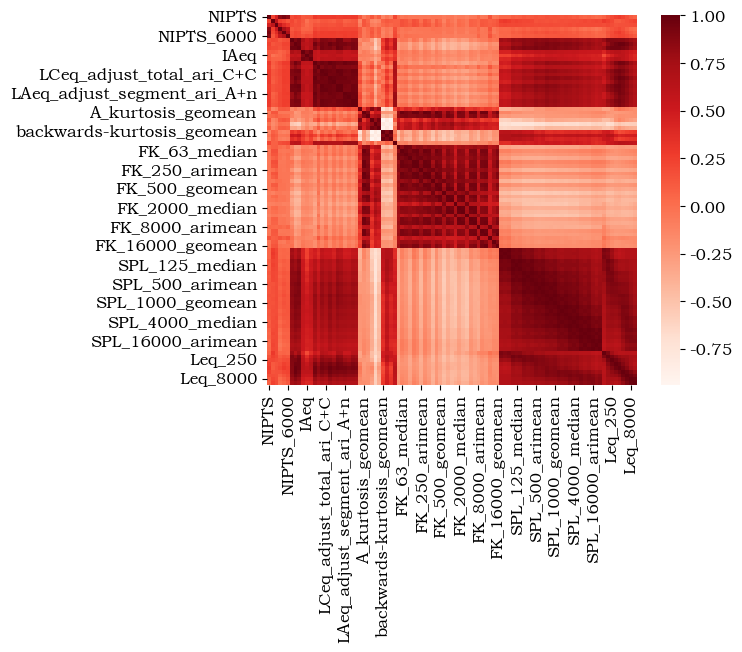

In [3]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix,annot = False,vmax = 1,square = True,cmap = "Reds")
plt.show()

In [8]:
label_columns = seq(df.columns).filter(lambda x: x.startswith("NIPTS")).list()
X = df.drop(label_columns, axis=1)
y = df.NIPTS

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

svm_model = SVR()

logger.info(SVR().get_params())

params = [
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "C": [1], "degree":[2, 3]},
    {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001]}
]

best_model = GridSearchCV(svm_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
best_model.fit(train_x, train_y)

logger.info(best_model.best_params_)
logger.info(best_model.best_estimator_)
logger.info(best_model.cv_results_)

2024-01-08 09:58:06.211 | INFO     | __main__:<module>:14 - {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [51]:
def RF_poly(df, poly=1):
    X = df.drop("NIPTS", axis=1)
    y = df.NIPTS

    poly = PolynomialFeatures(degree=poly, include_bias=False)
    X = poly.fit_transform(X)

    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

    tree_model = RandomForestRegressor()
    tree_model.fit(train_x, train_y)

    y_predict = tree_model.predict(test_x)
    rmse = mean_absolute_error(test_y, y_predict)
    logger.info(f"RMSE={rmse}")

    importances = tree_model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(importances)), importances[indices])
    ax.set_yticks(range(len(importances)))
    _ = ax.set_yticklabels(np.array(poly.get_feature_names_out())[indices])
    logger.info("\n".join(np.array(poly.get_feature_names_out())[indices]))
    
    plt.show()

# Feature filter

In [27]:
label_columns = seq(df.columns).filter(lambda x: x.startswith("NIPTS")).list()
X = df.drop(label_columns, axis=1).copy()
y = df.NIPTS

model, importances_res = get_importance_from_regressor(
                X=X,
                y=y,
                catboost_regressor_params=catboost_regressor_params,
                poly_degree=1)
importances = seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()
for k, v in importances.items():
    print(f"{k}:{v}")


0:	learn: 11.8173396	total: 62.9ms	remaining: 6.22s
50:	learn: 7.1409977	total: 2.89s	remaining: 2.78s


2024-01-08 15:14:35.816 | INFO     | comparasion_between_AC:get_importance_from_regressor:172 - ALL feature for model NIPTS: MAE = 9.3823


99:	learn: 4.8526091	total: 5.56s	remaining: 0us
LAeq_adjust_segment_ari_A+A:3.710485383113796
LCeq_adjust_segment_ari_C+n:3.400449781248654
LCeq_adjust_segment_ari_C+C:3.177387126027733
SPL_16000_median:2.5687404925089883
FK_16000_median:2.3616404622632015
SPL_8000_median:2.33818048152786
FK_16000_arimean:2.184027743606621
FK_16000_geomean:2.0852315255873943
SPL_4000_median:2.0253852290193537
FK_125_median:1.8787959804103738
Leq_63:1.8587142065409712
log-C_kurtosis_geomean:1.830581753094351
LAeq_adjust_segment_ari_A+n:1.8268396490445828
FK_63_geomean:1.7898772643013774
FK_8000_arimean:1.7018760870845082
kurtosis_geomean:1.698747252944823
IAeq:1.6179286246263767
Leq_4000:1.6065873026725053
max_Peak_SPL_dB:1.581741553346413
FK_63_median:1.5229253937024483
LAeq_adjust_total_ari_A+n:1.4680654868662255
Leq_2000:1.4562252316103188
log-A_kurtosis_geomean:1.3527658941651772
SPL_16000_arimean:1.3492094879280556
A_kurtosis_geomean:1.3285758026411507
SPL_16000_geomean:1.2747150939050507
FK_125_a

In [45]:
label_columns = seq(df.columns).filter(lambda x: x.startswith("NIPTS")).list()
X = df[[
    "LAeq",
    "LCeq",
    "Leq",
    "LAeq_adjust_segment_ari_A+A", 
    "LCeq_adjust_segment_ari_C+C", 
    "LAeq_adjust_total_ari_A+A",
    "LCeq_adjust_total_ari_C+C",
    "LAeq_adjust_total_geo_A+A",
    "LCeq_adjust_total_geo_C+C"
]]
y = df.NIPTS

model, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)
importances = seq(importances_res.items()).sorted(lambda x: x[1],
                                                  reverse=True).dict()
for k, v in importances.items():
    print(f"{k}:{v}")

0:	learn: 11.8267989	total: 12.3ms	remaining: 1.21s
50:	learn: 8.4310679	total: 446ms	remaining: 429ms


2024-01-08 15:53:43.035 | INFO     | comparasion_between_AC:get_importance_from_regressor:172 - ALL feature for model NIPTS: MAE = 9.8049


99:	learn: 6.8018010	total: 877ms	remaining: 0us
Leq:15.053366995494095
LAeq:13.63313912772112
LAeq_adjust_total_geo_A+A:12.102997310500417
LCeq_adjust_segment_ari_C+C:11.870338756540553
LAeq_adjust_segment_ari_A+A:11.421387602713652
LAeq_adjust_total_ari_A+A:10.471868080005665
LCeq_adjust_total_geo_C+C:9.561375704939053
LCeq:9.34834577893396
LCeq_adjust_total_ari_C+C:6.537180643151497


In [44]:
X = df[[
    "LAeq_adjust_segment_ari_A+A", 
    "LCeq_adjust_segment_ari_C+C", 
    "LAeq_adjust_total_ari_A+A",
    "LCeq_adjust_total_ari_C+C",
    "LAeq_adjust_total_geo_A+A",
    "LCeq_adjust_total_geo_C+C"
]]
y = df.NIPTS

model, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=2)
importances = seq(importances_res.items()).sorted(lambda x: x[1],
                                                  reverse=True).dict()
for k, v in importances.items():
    print(f"{k}:{v}")

0:	learn: 11.8436526	total: 19.1ms	remaining: 1.89s
50:	learn: 9.2443761	total: 885ms	remaining: 850ms


2024-01-08 15:49:51.969 | INFO     | comparasion_between_AC:get_importance_from_regressor:172 - ALL feature for model NIPTS: MAE = 9.8286


99:	learn: 7.8657222	total: 1.69s	remaining: 0us
LCeq_adjust_total_ari_C+C LCeq_adjust_total_geo_C+C:7.097178424714001
LAeq_adjust_segment_ari_A+A LAeq_adjust_total_geo_A+A:6.967058418100945
LCeq_adjust_total_geo_C+C:6.722825231195411
LCeq_adjust_segment_ari_C+C:6.687587153746939
LAeq_adjust_total_geo_A+A:6.588515519686412
LAeq_adjust_total_ari_A+A LAeq_adjust_total_geo_A+A:6.582430240409285
LAeq_adjust_total_ari_A+A:5.117678337325416
LAeq_adjust_segment_ari_A+A LCeq_adjust_total_geo_C+C:4.7770107945724565
LAeq_adjust_total_ari_A+A LCeq_adjust_total_geo_C+C:4.611202040372342
LCeq_adjust_total_ari_C+C:4.455850232106749
LCeq_adjust_segment_ari_C+C LAeq_adjust_total_ari_A+A:4.396730606642534
LCeq_adjust_total_ari_C+C LAeq_adjust_total_geo_A+A:4.216378362814574
LCeq_adjust_segment_ari_C+C LAeq_adjust_total_geo_A+A:4.209884325166429
LAeq_adjust_total_geo_A+A LCeq_adjust_total_geo_C+C:4.160159312876207
LAeq_adjust_segment_ari_A+A:4.064360871336292
LAeq_adjust_segment_ari_A+A LCeq_adjust_tota

In [ ]:
feature_filter_1st = seq(importances.items()).filter(lambda x: x[1]>1).map(lambda x: x[0]).list()
X_1st = X[feature_filter_1st]
model, importances_res = get_importance_from_regressor(
                X=X_1st,
                y=y,
                catboost_regressor_params=catboost_regressor_params,
                poly_degree=1)
importances_1st = seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()
for k, v in importances_1st.items():
    print(f"{k}:{v}")

# Feature accumulation

In [26]:
extract_df = pd.read_csv("./results/extract_df.csv", header=0, index_col="staff_id")
model_path = Path("./models/")
initial_features = [
            "LAeq", "LCeq", "Leq", "LAeq_adjust_segment_ari_A+A",
            "LCeq_adjust_segment_ari_C+C", "LAeq_adjust_total_ari_A+A",
            "LCeq_adjust_total_ari_C+C", "LAeq_adjust_total_geo_A+A",
            "LCeq_adjust_total_geo_C+C"
        ]


## Sequential search

In [ ]:
initial_features_search = [
            "LAeq", "LCeq", "Leq", "LAeq_adjust_segment_ari_A+A",
            "LCeq_adjust_segment_ari_C+C", "LAeq_adjust_total_ari_A+A",
            "LCeq_adjust_total_ari_C+C", "LAeq_adjust_total_geo_A+A",
            "LCeq_adjust_total_geo_C+C"
        ]
MAE_scores = {}
X = extract_df[initial_features_search]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)
# pickle.dump(
#     model,
#     open(model_path / f"regression_model_for_ini_features.pkl", "wb"))
MAE_scores["initial"] = MAE

append_features = seq(
    extract_df.columns).filter(lambda x: not x.startswith(
        "NIPTS")).filter(lambda x: not x in initial_features_search).list()
for append_feature in append_features:
    initial_features_search.append(append_feature)
    X = extract_df[initial_features_search]
    model, MAE, importances_res = get_importance_from_regressor(
        X=X,
        y=y,
        catboost_regressor_params=catboost_regressor_params,
        poly_degree=1)
    # pickle.dump(
    #     model,
    #     open(
    #         model_path /
    #         f"regression_model_for_add-{append_feature}.pkl", "wb"))
    MAE_scores[f"add-{append_feature}"] = MAE

fig, ax = plt.subplots(1, figsize=(6.5,5))
ax.plot(range(len(MAE_scores)), MAE_scores.values(), marker="o")
plt.show()

### Best Model

In [12]:
seq(MAE_scores.items()).sorted(lambda x: x[1]).list()[:5]

[('add-FK_500_median', 9.10418201272268),
 ('add-Leq_500', 9.17333506009425),
 ('add-Leq_63', 9.236539500216852),
 ('add-FK_2000_median', 9.291674651283499),
 ('add-SPL_250_median', 9.29577120640995)]

In [30]:
useful_features = initial_features + append_features[:append_features.index("FK_500_median")+1]
X = extract_df[useful_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)


0:	learn: 11.8321442	total: 53.3ms	remaining: 5.27s
50:	learn: 7.3812068	total: 1.38s	remaining: 1.33s


2024-01-08 17:02:47.459 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.1042


99:	learn: 5.2027028	total: 2.63s	remaining: 0us


In [21]:
len(model.feature_importances_)

39

## Random search

In [43]:
random.sample(append_features,k=1)

['FK_8000_geomean']

0:	learn: 11.8267989	total: 16ms	remaining: 1.58s
50:	learn: 8.4310679	total: 444ms	remaining: 427ms


2024-01-08 17:39:50.934 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.8049


99:	learn: 6.8018010	total: 847ms	remaining: 0us
0:	learn: 11.8295643	total: 13.8ms	remaining: 1.37s
50:	learn: 8.5308718	total: 466ms	remaining: 448ms


2024-01-08 17:39:51.966 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4028


99:	learn: 6.7826024	total: 912ms	remaining: 0us
0:	learn: 11.8173876	total: 13.6ms	remaining: 1.35s
50:	learn: 8.1993536	total: 479ms	remaining: 460ms


2024-01-08 17:39:53.026 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.7376


99:	learn: 6.4610942	total: 939ms	remaining: 0us
0:	learn: 11.8272563	total: 15.6ms	remaining: 1.55s
50:	learn: 8.2508815	total: 520ms	remaining: 500ms


2024-01-08 17:39:54.144 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4551


99:	learn: 6.4860257	total: 1000ms	remaining: 0us
0:	learn: 11.8048379	total: 14ms	remaining: 1.39s
50:	learn: 8.1085400	total: 556ms	remaining: 534ms


2024-01-08 17:39:55.301 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5058


99:	learn: 6.3249706	total: 1.04s	remaining: 0us
0:	learn: 11.8415991	total: 16.5ms	remaining: 1.63s
50:	learn: 8.0817656	total: 582ms	remaining: 559ms


2024-01-08 17:39:56.536 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.263


99:	learn: 6.2711043	total: 1.11s	remaining: 0us
0:	learn: 11.8135655	total: 15.5ms	remaining: 1.53s
50:	learn: 7.7431622	total: 648ms	remaining: 623ms


2024-01-08 17:39:57.912 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6745


99:	learn: 5.8104888	total: 1.25s	remaining: 0us
0:	learn: 11.7980133	total: 16.8ms	remaining: 1.66s
50:	learn: 7.8734196	total: 627ms	remaining: 602ms


2024-01-08 17:39:59.270 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5054


99:	learn: 5.9760298	total: 1.23s	remaining: 0us
0:	learn: 11.7801057	total: 18.3ms	remaining: 1.81s
50:	learn: 7.5832024	total: 671ms	remaining: 644ms


2024-01-08 17:40:00.671 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.7723


99:	learn: 5.7294813	total: 1.28s	remaining: 0us
0:	learn: 11.8058722	total: 21.2ms	remaining: 2.1s
50:	learn: 7.5758978	total: 716ms	remaining: 688ms


2024-01-08 17:40:02.138 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6813


99:	learn: 5.5654344	total: 1.34s	remaining: 0us
0:	learn: 11.7810098	total: 22.8ms	remaining: 2.25s
50:	learn: 7.6365309	total: 787ms	remaining: 756ms


2024-01-08 17:40:03.713 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.482


99:	learn: 5.7314730	total: 1.45s	remaining: 0us
0:	learn: 11.7781905	total: 21.1ms	remaining: 2.09s
50:	learn: 7.6491816	total: 795ms	remaining: 764ms


2024-01-08 17:40:05.363 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.916


99:	learn: 5.5213786	total: 1.54s	remaining: 0us
0:	learn: 11.7867742	total: 22.6ms	remaining: 2.24s
50:	learn: 7.7233186	total: 890ms	remaining: 855ms


2024-01-08 17:40:07.207 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.8556


99:	learn: 5.9059184	total: 1.72s	remaining: 0us
0:	learn: 11.8029037	total: 47.8ms	remaining: 4.74s
50:	learn: 7.5436391	total: 957ms	remaining: 919ms


2024-01-08 17:40:09.116 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.684


99:	learn: 5.5176523	total: 1.78s	remaining: 0us
0:	learn: 11.7978799	total: 24.5ms	remaining: 2.43s
50:	learn: 7.5069179	total: 970ms	remaining: 932ms


2024-01-08 17:40:11.052 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5981


99:	learn: 5.5708660	total: 1.81s	remaining: 0us
0:	learn: 11.7808997	total: 23.9ms	remaining: 2.36s
50:	learn: 7.4619665	total: 973ms	remaining: 934ms


2024-01-08 17:40:13.069 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.8925


99:	learn: 5.5623727	total: 1.9s	remaining: 0us
0:	learn: 11.7842028	total: 23.9ms	remaining: 2.37s
50:	learn: 7.4739725	total: 1s	remaining: 962ms


2024-01-08 17:40:15.130 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3989


99:	learn: 5.5832833	total: 1.94s	remaining: 0us
0:	learn: 11.7969906	total: 29.6ms	remaining: 2.93s
50:	learn: 7.5575091	total: 1.06s	remaining: 1.02s


2024-01-08 17:40:17.299 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3385


99:	learn: 5.4985797	total: 2.05s	remaining: 0us
0:	learn: 11.7886469	total: 26.2ms	remaining: 2.59s
50:	learn: 7.4325536	total: 1.03s	remaining: 992ms


2024-01-08 17:40:19.448 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6274


99:	learn: 5.4087565	total: 2.03s	remaining: 0us
0:	learn: 11.7928349	total: 27.5ms	remaining: 2.72s
50:	learn: 7.5580664	total: 1.19s	remaining: 1.14s


2024-01-08 17:40:21.773 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3618


99:	learn: 5.4573483	total: 2.21s	remaining: 0us
0:	learn: 11.8036042	total: 29.7ms	remaining: 2.94s
50:	learn: 7.4123611	total: 1.12s	remaining: 1.08s


2024-01-08 17:40:24.049 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.7056


99:	learn: 5.3918638	total: 2.15s	remaining: 0us
0:	learn: 11.7878240	total: 28.4ms	remaining: 2.82s
50:	learn: 7.4645742	total: 1.18s	remaining: 1.13s


2024-01-08 17:40:26.390 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6117


99:	learn: 5.4017527	total: 2.22s	remaining: 0us
0:	learn: 11.7850556	total: 28.7ms	remaining: 2.84s
50:	learn: 7.4341612	total: 1.14s	remaining: 1.09s


2024-01-08 17:40:28.725 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4301


99:	learn: 5.3790985	total: 2.21s	remaining: 0us
0:	learn: 11.7826155	total: 36ms	remaining: 3.56s
50:	learn: 7.4948008	total: 1.19s	remaining: 1.15s


2024-01-08 17:40:31.116 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4113


99:	learn: 5.4319990	total: 2.27s	remaining: 0us
0:	learn: 11.7932821	total: 33.4ms	remaining: 3.31s
50:	learn: 7.6013146	total: 1.17s	remaining: 1.12s


2024-01-08 17:40:33.576 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3016


99:	learn: 5.4734726	total: 2.34s	remaining: 0us
0:	learn: 11.8025281	total: 32.3ms	remaining: 3.19s
50:	learn: 7.4232638	total: 1.32s	remaining: 1.27s


2024-01-08 17:40:36.185 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.7746


99:	learn: 5.3739309	total: 2.47s	remaining: 0us
0:	learn: 11.8066451	total: 35ms	remaining: 3.46s
50:	learn: 7.4212227	total: 1.31s	remaining: 1.26s


2024-01-08 17:40:38.760 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4756


99:	learn: 5.3938145	total: 2.44s	remaining: 0us
0:	learn: 11.8086114	total: 30.7ms	remaining: 3.04s
50:	learn: 7.3755731	total: 1.33s	remaining: 1.27s


2024-01-08 17:40:41.419 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6193


99:	learn: 5.3390362	total: 2.52s	remaining: 0us
0:	learn: 11.7855550	total: 35.4ms	remaining: 3.51s
50:	learn: 7.2593775	total: 1.36s	remaining: 1.3s


2024-01-08 17:40:44.169 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3791


99:	learn: 5.1963752	total: 2.63s	remaining: 0us
0:	learn: 11.7847622	total: 35.9ms	remaining: 3.55s
50:	learn: 7.4222164	total: 1.42s	remaining: 1.36s


2024-01-08 17:40:46.971 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5042


99:	learn: 5.2788756	total: 2.67s	remaining: 0us
0:	learn: 11.7904971	total: 35.1ms	remaining: 3.48s
50:	learn: 7.3917667	total: 1.41s	remaining: 1.35s


2024-01-08 17:40:49.812 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6595


99:	learn: 5.3087175	total: 2.72s	remaining: 0us
0:	learn: 11.8002521	total: 38.7ms	remaining: 3.83s
50:	learn: 7.3603027	total: 1.44s	remaining: 1.39s


2024-01-08 17:40:52.697 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4752


99:	learn: 5.3417896	total: 2.76s	remaining: 0us
0:	learn: 11.7803826	total: 53ms	remaining: 5.24s
50:	learn: 7.3276507	total: 1.5s	remaining: 1.45s


2024-01-08 17:40:55.664 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.509


99:	learn: 5.1310966	total: 2.83s	remaining: 0us
0:	learn: 11.8251613	total: 39.8ms	remaining: 3.94s
50:	learn: 7.2908560	total: 1.52s	remaining: 1.47s


2024-01-08 17:40:58.682 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.7138


99:	learn: 5.1466236	total: 2.87s	remaining: 0us
0:	learn: 11.8325477	total: 40.4ms	remaining: 4s
50:	learn: 7.4072611	total: 1.53s	remaining: 1.47s


2024-01-08 17:41:01.774 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5277


99:	learn: 5.1568607	total: 2.94s	remaining: 0us
0:	learn: 11.8129319	total: 40.7ms	remaining: 4.03s
50:	learn: 7.5592288	total: 1.53s	remaining: 1.47s


2024-01-08 17:41:04.980 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4736


99:	learn: 5.3506793	total: 3.02s	remaining: 0us
0:	learn: 11.7778168	total: 40.5ms	remaining: 4s
50:	learn: 7.3125609	total: 1.64s	remaining: 1.57s


2024-01-08 17:41:08.206 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4922


99:	learn: 5.1883549	total: 3.11s	remaining: 0us
0:	learn: 11.8224620	total: 42.4ms	remaining: 4.2s
50:	learn: 7.3007762	total: 1.6s	remaining: 1.54s


2024-01-08 17:41:11.391 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4768


99:	learn: 5.1487929	total: 3.08s	remaining: 0us
0:	learn: 11.8089917	total: 41.4ms	remaining: 4.1s
50:	learn: 7.3165492	total: 1.68s	remaining: 1.62s


2024-01-08 17:41:14.757 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5427


99:	learn: 5.0874259	total: 3.26s	remaining: 0us
0:	learn: 11.7788127	total: 39.7ms	remaining: 3.93s
50:	learn: 7.2763173	total: 1.72s	remaining: 1.65s


2024-01-08 17:41:18.143 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4406


99:	learn: 5.1335676	total: 3.26s	remaining: 0us
0:	learn: 11.8059066	total: 43.1ms	remaining: 4.26s
50:	learn: 7.4258338	total: 1.76s	remaining: 1.69s


2024-01-08 17:41:21.635 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.2076


99:	learn: 5.1927872	total: 3.37s	remaining: 0us
0:	learn: 11.7808301	total: 43.9ms	remaining: 4.34s
50:	learn: 7.3042602	total: 1.8s	remaining: 1.73s


2024-01-08 17:41:25.226 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5672


99:	learn: 5.0559040	total: 3.46s	remaining: 0us
0:	learn: 11.7922842	total: 47.1ms	remaining: 4.66s
50:	learn: 7.2887327	total: 1.82s	remaining: 1.75s


2024-01-08 17:41:28.878 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5989


99:	learn: 5.0913809	total: 3.52s	remaining: 0us
0:	learn: 11.7731532	total: 41.7ms	remaining: 4.13s
50:	learn: 7.1423969	total: 1.79s	remaining: 1.72s


2024-01-08 17:41:32.486 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.519


99:	learn: 4.9868389	total: 3.48s	remaining: 0us
0:	learn: 11.7810470	total: 47.9ms	remaining: 4.74s
50:	learn: 7.3269359	total: 1.85s	remaining: 1.78s


2024-01-08 17:41:36.161 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3889


99:	learn: 4.9960962	total: 3.55s	remaining: 0us
0:	learn: 11.7818695	total: 52.7ms	remaining: 5.22s
50:	learn: 7.2788769	total: 1.89s	remaining: 1.81s


2024-01-08 17:41:39.923 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4215


99:	learn: 5.0409497	total: 3.62s	remaining: 0us
0:	learn: 11.7796233	total: 44.8ms	remaining: 4.44s
50:	learn: 7.0916046	total: 1.9s	remaining: 1.82s


2024-01-08 17:41:43.712 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3353


99:	learn: 4.9671286	total: 3.67s	remaining: 0us
0:	learn: 11.7982214	total: 50.8ms	remaining: 5.03s
50:	learn: 7.2456039	total: 1.96s	remaining: 1.89s


2024-01-08 17:41:47.607 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6091


99:	learn: 5.0470682	total: 3.77s	remaining: 0us
0:	learn: 11.7939259	total: 49.6ms	remaining: 4.91s
50:	learn: 7.1853797	total: 2.01s	remaining: 1.93s


2024-01-08 17:41:51.556 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4157


99:	learn: 4.9912059	total: 3.82s	remaining: 0us
0:	learn: 11.7810476	total: 49.8ms	remaining: 4.93s
50:	learn: 7.0747416	total: 2.04s	remaining: 1.96s


2024-01-08 17:41:55.605 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3638


99:	learn: 4.9266888	total: 3.93s	remaining: 0us
0:	learn: 11.8004740	total: 73.7ms	remaining: 7.29s
50:	learn: 7.2240039	total: 2.1s	remaining: 2.02s


2024-01-08 17:41:59.692 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.376


99:	learn: 5.0081850	total: 3.95s	remaining: 0us
0:	learn: 11.7938346	total: 53.8ms	remaining: 5.32s
50:	learn: 7.2359724	total: 2.08s	remaining: 1.99s


2024-01-08 17:42:03.832 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5057


99:	learn: 4.9846823	total: 4.02s	remaining: 0us
0:	learn: 11.8069553	total: 52.2ms	remaining: 5.17s
50:	learn: 7.1336334	total: 2.17s	remaining: 2.09s


2024-01-08 17:42:08.150 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5201


99:	learn: 4.8258773	total: 4.18s	remaining: 0us
0:	learn: 11.7831703	total: 54.9ms	remaining: 5.44s
50:	learn: 7.1392034	total: 2.2s	remaining: 2.11s


2024-01-08 17:42:12.510 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3104


99:	learn: 4.8320695	total: 4.23s	remaining: 0us
0:	learn: 11.8036769	total: 50.9ms	remaining: 5.04s
50:	learn: 7.1718104	total: 2.18s	remaining: 2.1s


2024-01-08 17:42:16.832 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4451


99:	learn: 4.9434096	total: 4.21s	remaining: 0us
0:	learn: 11.7940442	total: 58.8ms	remaining: 5.82s
50:	learn: 7.0490163	total: 2.25s	remaining: 2.16s


2024-01-08 17:42:21.267 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4436


99:	learn: 4.9067550	total: 4.3s	remaining: 0us
0:	learn: 11.7824276	total: 50.3ms	remaining: 4.98s
50:	learn: 6.9862141	total: 2.28s	remaining: 2.19s


2024-01-08 17:42:25.769 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3568


99:	learn: 4.8695013	total: 4.38s	remaining: 0us
0:	learn: 11.7899525	total: 58.3ms	remaining: 5.77s
50:	learn: 7.1427586	total: 2.32s	remaining: 2.23s


2024-01-08 17:42:30.317 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4861


99:	learn: 4.8029041	total: 4.42s	remaining: 0us
0:	learn: 11.7826554	total: 55.7ms	remaining: 5.52s
50:	learn: 7.0304679	total: 2.35s	remaining: 2.25s


2024-01-08 17:42:34.946 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.532


99:	learn: 4.8691254	total: 4.49s	remaining: 0us
0:	learn: 11.8132268	total: 49.4ms	remaining: 4.89s
50:	learn: 7.1758850	total: 2.42s	remaining: 2.32s


2024-01-08 17:42:39.736 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4131


99:	learn: 4.9007541	total: 4.64s	remaining: 0us
0:	learn: 11.7886269	total: 54.8ms	remaining: 5.43s
50:	learn: 7.2720165	total: 2.41s	remaining: 2.32s


2024-01-08 17:42:44.436 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4713


99:	learn: 4.9773541	total: 4.57s	remaining: 0us
0:	learn: 11.7829416	total: 62.5ms	remaining: 6.18s
50:	learn: 7.2351018	total: 2.45s	remaining: 2.35s


2024-01-08 17:42:49.363 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5032


99:	learn: 4.9642042	total: 4.8s	remaining: 0us
0:	learn: 11.8151186	total: 51.3ms	remaining: 5.08s
50:	learn: 7.1998525	total: 2.52s	remaining: 2.42s


2024-01-08 17:42:54.312 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4002


99:	learn: 4.9474366	total: 4.83s	remaining: 0us
0:	learn: 11.7938973	total: 60.9ms	remaining: 6.02s
50:	learn: 7.2306246	total: 2.55s	remaining: 2.45s


2024-01-08 17:42:59.329 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3739


99:	learn: 4.9263744	total: 4.89s	remaining: 0us
0:	learn: 11.7769363	total: 57.9ms	remaining: 5.73s
50:	learn: 7.1358985	total: 2.55s	remaining: 2.45s


2024-01-08 17:43:04.276 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4117


99:	learn: 4.9629394	total: 4.82s	remaining: 0us
0:	learn: 11.8076590	total: 61.1ms	remaining: 6.05s
50:	learn: 7.1654938	total: 2.56s	remaining: 2.46s


2024-01-08 17:43:09.364 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5975


99:	learn: 4.7795688	total: 4.97s	remaining: 0us
0:	learn: 11.8208599	total: 62.5ms	remaining: 6.19s
50:	learn: 7.1923206	total: 2.64s	remaining: 2.54s


2024-01-08 17:43:14.506 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3845


99:	learn: 4.8087986	total: 5.01s	remaining: 0us
0:	learn: 11.7912775	total: 59.2ms	remaining: 5.86s
50:	learn: 7.1554190	total: 2.62s	remaining: 2.52s


2024-01-08 17:43:19.534 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.2473


99:	learn: 4.9169433	total: 4.89s	remaining: 0us
0:	learn: 11.8068188	total: 59.7ms	remaining: 5.91s
50:	learn: 7.1284265	total: 2.64s	remaining: 2.54s


2024-01-08 17:43:24.676 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.1416


99:	learn: 4.8562527	total: 5.01s	remaining: 0us
0:	learn: 11.7939314	total: 69.9ms	remaining: 6.92s
50:	learn: 7.0997756	total: 2.68s	remaining: 2.58s


2024-01-08 17:43:29.917 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.598


99:	learn: 4.8713935	total: 5.12s	remaining: 0us
0:	learn: 11.8156798	total: 57.8ms	remaining: 5.72s
50:	learn: 7.0171200	total: 2.69s	remaining: 2.58s


2024-01-08 17:43:35.210 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.477


99:	learn: 4.7155028	total: 5.15s	remaining: 0us
0:	learn: 11.7964315	total: 65.3ms	remaining: 6.46s
50:	learn: 7.0454395	total: 2.71s	remaining: 2.6s


2024-01-08 17:43:40.702 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.2471


99:	learn: 4.6616029	total: 5.37s	remaining: 0us
0:	learn: 11.8032504	total: 63.8ms	remaining: 6.32s
50:	learn: 7.0623288	total: 2.82s	remaining: 2.71s


2024-01-08 17:43:46.262 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3435


99:	learn: 4.7194930	total: 5.44s	remaining: 0us
0:	learn: 11.8316122	total: 62.9ms	remaining: 6.23s
50:	learn: 7.0174833	total: 2.82s	remaining: 2.71s


2024-01-08 17:43:51.712 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.522


99:	learn: 4.8893855	total: 5.33s	remaining: 0us
0:	learn: 11.7975648	total: 65.2ms	remaining: 6.46s
50:	learn: 7.1646923	total: 2.82s	remaining: 2.71s


2024-01-08 17:43:57.320 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4022


99:	learn: 4.8607909	total: 5.49s	remaining: 0us
0:	learn: 11.7945087	total: 63.3ms	remaining: 6.26s
50:	learn: 7.0546846	total: 2.87s	remaining: 2.75s


2024-01-08 17:44:02.989 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6018


99:	learn: 4.8635489	total: 5.54s	remaining: 0us
0:	learn: 11.8090410	total: 63.3ms	remaining: 6.26s
50:	learn: 7.0727217	total: 2.88s	remaining: 2.77s


2024-01-08 17:44:08.681 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.4298


99:	learn: 4.8359798	total: 5.56s	remaining: 0us
0:	learn: 11.8142502	total: 73.3ms	remaining: 7.25s
50:	learn: 7.0828727	total: 3.11s	remaining: 2.99s


2024-01-08 17:44:14.674 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.3826


99:	learn: 4.7924991	total: 5.83s	remaining: 0us
0:	learn: 11.7569037	total: 82.5ms	remaining: 8.17s
50:	learn: 7.1612968	total: 2.96s	remaining: 2.84s


2024-01-08 17:44:20.540 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.225


99:	learn: 4.9198888	total: 5.73s	remaining: 0us
0:	learn: 11.8172130	total: 76.4ms	remaining: 7.57s
50:	learn: 7.1890060	total: 3.21s	remaining: 3.08s


2024-01-08 17:44:26.940 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.6698


99:	learn: 4.8823737	total: 6.26s	remaining: 0us
0:	learn: 11.7888023	total: 69.8ms	remaining: 6.91s
50:	learn: 7.1894361	total: 6.99s	remaining: 6.72s


2024-01-08 17:44:41.025 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5035


99:	learn: 4.8255886	total: 13.9s	remaining: 0us
0:	learn: 11.7730219	total: 163ms	remaining: 16.1s
50:	learn: 7.1483596	total: 7.44s	remaining: 7.15s


2024-01-08 17:44:55.657 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5137


99:	learn: 4.9040439	total: 14.4s	remaining: 0us
0:	learn: 11.7664088	total: 140ms	remaining: 13.9s
50:	learn: 7.0740129	total: 5.92s	remaining: 5.69s


2024-01-08 17:45:04.934 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.0078


99:	learn: 4.8875124	total: 9.12s	remaining: 0us


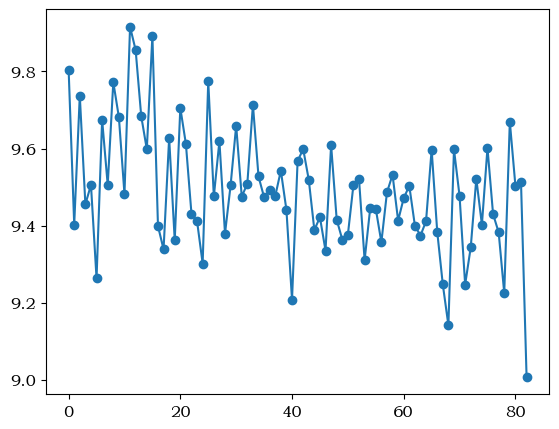

In [52]:
initial_features_search = [
    "LAeq", "LCeq", "Leq", "LAeq_adjust_segment_ari_A+A",
    "LCeq_adjust_segment_ari_C+C", "LAeq_adjust_total_ari_A+A",
    "LCeq_adjust_total_ari_C+C", "LAeq_adjust_total_geo_A+A",
    "LCeq_adjust_total_geo_C+C"
]
MAE_scores = {}
X = extract_df[initial_features_search]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)
MAE_scores["initial"] = MAE

append_features = seq(
    extract_df.columns).filter(lambda x: not x.startswith("NIPTS")).filter(
        lambda x: not x in initial_features_search).list()
while len(initial_features_search) < len(
        seq(extract_df.columns).filter(
            lambda x: not x.startswith("NIPTS")).list()):
    append_feature = random.sample(append_features,k=1)[0]
    append_features.pop(append_features.index(append_feature))
    initial_features_search.append(append_feature)
    X = extract_df[initial_features_search]
    model, MAE, importances_res = get_importance_from_regressor(
        X=X,
        y=y,
        catboost_regressor_params=catboost_regressor_params,
        poly_degree=1)
    MAE_scores[f"add-{append_feature}"] = MAE

fig, ax = plt.subplots(1, figsize=(6.5, 5))
ax.plot(range(len(MAE_scores)), MAE_scores.values(), marker="o")
plt.show()

### Best Model

In [53]:
seq(MAE_scores.items()).sorted(lambda x: x[1]).list()[:5]

[('add-SPL_2000_arimean', 9.007755040758655),
 ('add-FK_8000_geomean', 9.141586274423497),
 ('add-SPL_2000_geomean', 9.207603809761789),
 ('add-FK_2000_median', 9.224980874417811),
 ('add-FK_250_geomean', 9.247099150167017)]

In [50]:
initial_features_search

['LAeq',
 'LCeq',
 'Leq',
 'LAeq_adjust_segment_ari_A+A',
 'LCeq_adjust_segment_ari_C+C',
 'LAeq_adjust_total_ari_A+A',
 'LCeq_adjust_total_ari_C+C',
 'LAeq_adjust_total_geo_A+A',
 'LCeq_adjust_total_geo_C+C',
 'log-kurtosis_geomean',
 'SPL_8000_arimean',
 'SPL_500_arimean',
 'backwards-kurtosis_geomean',
 'IAeq',
 'FK_16000_geomean',
 'ICeq',
 'FK_500_median',
 'SPL_1000_geomean',
 'FK_125_arimean',
 'FK_2000_median',
 'log-A_kurtosis_geomean',
 'A_kurtosis_geomean',
 'C_kurtosis_geomean',
 'FK_16000_arimean',
 'IAeq',
 'SPL_8000_geomean',
 'FK_63_median',
 'A_kurtosis_geomean',
 'log-A_kurtosis_geomean',
 'SPL_125_geomean',
 'LCeq_adjust_total_ari_C+n',
 'LAeq_adjust_segment_ari_A+n',
 'SPL_8000_arimean',
 'LAeq_adjust_total_geo_A+n',
 'SPL_63_geomean',
 'FK_250_median',
 'SPL_16000_arimean',
 'SPL_250_arimean',
 'FK_8000_geomean',
 'SPL_250_arimean',
 'Leq_1000',
 'Leq_63',
 'LAeq_adjust_total_ari_A+n',
 'LAeq_adjust_total_ari_A+n',
 'SPL_2000_geomean',
 'FK_63_arimean',
 'SPL_2000_

In [37]:
useful_features = initial_features_search[:initial_features_search.index("FK_63_arimean")+1]
X = extract_df[useful_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

0:	learn: 11.7934137	total: 61.5ms	remaining: 6.09s
50:	learn: 7.1927768	total: 2.88s	remaining: 2.76s


2024-01-08 17:20:26.928 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 9.5226


99:	learn: 4.8979124	total: 5.51s	remaining: 0us
